### Import modules

In [1]:
##########################################
#           Module import                #
##########################################

import ee
from datetime import datetime
from IPython.display import Image, display, HTML
from ee_ipl_uv_perso import multitemporal_cloud_masking
from ee_ipl_uv_perso import download
import os
import requests
import ee.mapclient

ee.Initialize()

RED: str = 'B4'
GREEN: str = 'B3'
BLUE: str = 'B2'
NIR: str = 'B8'
IMAGE_DIM: str = "400x400"
dataset_index: str = "COPERNICUS/S2"
image_index: str = '20150628T113527_20160606T031146_T30VVJ'
NB_PREVIOUS_IMAGE: int = 10


### Data import

In [2]:
##########################################
#            Data imports                #
##########################################

# Define area of interest
region_of_interest = ee.Geometry.Polygon(
    [[[-4.039076897912651, 56.91830208635256],
      [-4.039076897912651, 56.7727863740981],
      [-3.7245932553345256, 56.7727863740981],
      [-3.7245932553345256, 56.91830208635256]]])

# Select image to remove clouds
image_predict_clouds = ee.Image(dataset_index + "/" + image_index)

# Select datasat
""" dataset = ee.ImageCollection(dataset_index) \
    .select([RED, BLUE, GREEN, NIR]) \
    .filterBounds(region_of_interest)
 """

# Get image date
datetime_image = datetime.utcfromtimestamp(image_predict_clouds.get("system:time_start") \
                                                                .getInfo() / 1000) \
                                                                .strftime("%Y-%m-%d %H:%M:%S")


### Data import

In [3]:
##########################################
#            Data imports                #
##########################################

# Define area of interest
region_of_interest = ee.Geometry.Polygon(
    [[[-4.039076897912651, 56.91830208635256],
      [-4.039076897912651, 56.7727863740981],
      [-3.7245932553345256, 56.7727863740981],
      [-3.7245932553345256, 56.91830208635256]]])

# Select image to remove clouds
image_predict_clouds = ee.Image(dataset_index + "/" + image_index)

# Select datasat
""" dataset = ee.ImageCollection(dataset_index) \
    .select([RED, BLUE, GREEN, NIR]) \
    .filterBounds(region_of_interest)
 """

# Get image date
datetime_image = datetime.utcfromtimestamp(image_predict_clouds.get("system:time_start") \
                                                                .getInfo() / 1000) \
                                                                .strftime("%Y-%m-%d %H:%M:%S")


### Viz Image source

In [4]:
# Visualize area of interest
imageRGB = image_predict_clouds.visualize(max=8301,
                                          min=-1655,
                                          bands=[RED, GREEN, BLUE])

image_file_original = download.MaybeDownloadThumb(imageRGB.clip(region_of_interest),
                                                  params={"dimensions": IMAGE_DIM})

### Visualization Image

In [5]:
#################################
#     Visualization Image       #
#################################

def viz_cloudscore_mask(cloudscoremask):
    cloudscoremask_vis = cloudscoremask.updateMask(cloudscoremask)
    cloudscoremask_vis = cloudscoremask_vis.visualize(max=1,min=0,palette=['1f77b4', 'ff7f0e'])
    mosaic = ee.ImageCollection([imageRGB, cloudscoremask_vis]).mosaic()
    return download.MaybeDownloadThumb(mosaic.clip(region_of_interest),params={"dimensions": "400x400"})


### Persistence method

band names : ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA60']
collection name: COPERNICUS/S2


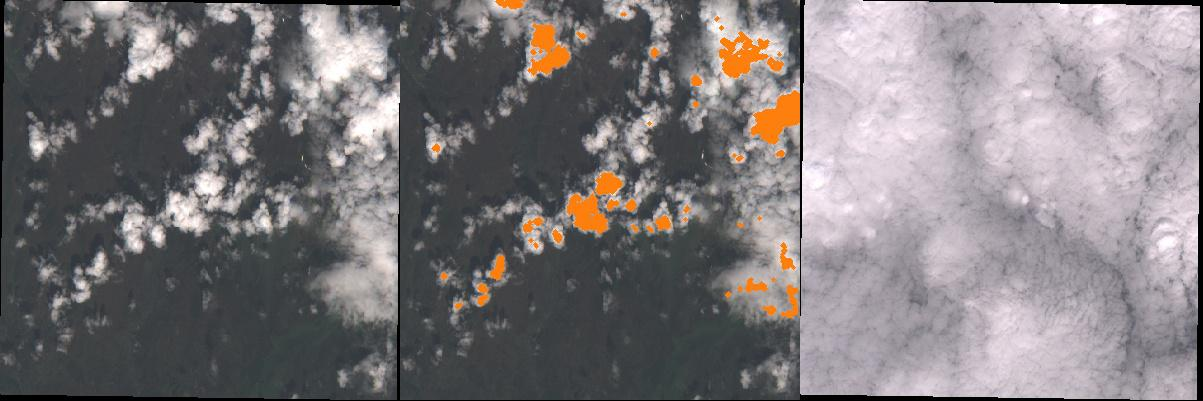

In [7]:
##############################
#     Persistence method     #
##############################
cloud_score_persistence, pred_persistence = multitemporal_cloud_masking. \
                            CloudClusterScore(image_predict_clouds, \
                                                region_of_interest, \
                                                method_pred="persistence")

persistence_pred_file = download.MaybeDownloadThumb(pred_persistence.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":8301,
                                                           "min":-1655})

list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_persistence), persistence_pred_file]

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
       HTML("<center>Sentinel2 image %s with clusterscore from persistence method cloud mask</center>"%datetime_image))